In [1]:
!pip install sklearn2pmml && pip install pypmml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 4.3 MB/s 
  Created wheel for sklearn2pmml: filename=sklearn2pmml-0.86.0-py3-none-any.whl size=6334248 sha256=4580544e970056e147c4d1e1b9620666a54933c6bd543541e179e8be8bc6ced1
  Stored in directory: /root/.cache/pip/wheels/66/1e/30/394b0b05900c577988fa2ed7c79fadee2fe40587a96ba49d49
Successfully built sklearn2pmml
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.0 MB 317 kB/s 
     |████████████████████████████████| 200 kB 35.1 MB/s 
  Created wheel for pypmml: filename=pypmml-0.9.16-py3-none-any.whl size=15047704 sha256=b0d6d2b87abe639968f652b33041efca468c5236105190e2d6e7c4656662e7ef
  Stored in directory: /root/.cache/pip/wheels/dc/54/78/12cc7079840b8ca2d1ee700de2d9fc3930380ee6e1c520d73b
Successfully built pypmml


In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import log_loss

from xgboost import XGBClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

from sklearn.pipeline import Pipeline

from sklearn2pmml.pipeline import PMMLPipeline
from sklearn2pmml import sklearn2pmml

from pypmml import Model

######

from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

In [3]:
df = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')

In [4]:
df = df[['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'alone', 'survived']]
df['sex'] = (df['sex'] == 'male').astype(int)
df['alone'] = (df['alone'] == 'y').astype(int)

In [5]:
features = ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'alone']
target = 'survived'

#Separação de Conjunto de Teste

In [6]:
split = ShuffleSplit(n_splits = 1, test_size = 0.1, random_state = 42)
split.get_n_splits(df)

for train_index, test_index in split.split(df):
    index_treino = train_index
    index_teste = test_index

In [7]:
df_teste = df.loc[index_teste, :].reset_index(drop = True).copy()
df = df.loc[index_treino, :].reset_index(drop = True).copy()

#Separação dos Conjuntos de Treino e Validação

In [8]:
split = ShuffleSplit(n_splits = 10, test_size = 0.25, random_state = 42)
split.get_n_splits(df)
lista_trainval = []
for train_index, val_index in split.split(df):
    lista_trainval.append((train_index, val_index))

#Treinamento com Validação

In [9]:
'''
def treino_xgboost(X_train, y_train, X_val, y_val, estimators):
    clf = XGBClassifier(n_estimators = estimators,
                        max_depth = 1, learning_rate = 0.1, 
                        random_state = 42)
    clf_vot = VotingClassifier(estimators = [('est', clf)], voting = 'soft')
    clf_vot.fit(X_train, y_train)
    return log_loss(y_train, clf_vot.predict_proba(X_train)[:, 1]), log_loss(y_val, clf_vot.predict_proba(X_val)[:, 1]), clf_vot


def treino_com_validacao(X_train, y_train, X_val, y_val, max_estimators = 100):
    v_estimators = np.arange(1, max_estimators+1)
    retorno = [treino_xgboost(X_train, y_train, X_val, y_val, estimators) for estimators in v_estimators]
    loss_train = np.array([v[0] for v in retorno])
    loss_val = np.array([v[1] for v in retorno])
    best_estimators = v_estimators[np.argmin(loss_val)]

    plot_curva_vies_variancia(v_estimators, loss_train, loss_val)

    _, _, clf = treino_xgboost(X_train, y_train, X_val, y_val, best_estimators)

    return clf
'''

def plot_curva_vies_variancia(v_pos, loss_train, loss_val):
    ind_min = np.argmin(loss_val)
    best_pos = v_pos[ind_min]
    paleta_cores = sns.color_palette("colorblind")
    with sns.axes_style("whitegrid"):
        fig, ax = plt.subplots(1, 1, figsize = (10, 6))
        ax.plot(v_pos, loss_train, color = paleta_cores[0], label = 'Treino')
        ax.scatter(best_pos, loss_train[ind_min], color = paleta_cores[0])
        ax.plot(v_pos, loss_val, color = paleta_cores[1], label = f'Validação ({str(best_pos)})')
        ax.scatter(best_pos, loss_val[ind_min], color = paleta_cores[1])
        ax.set_xlabel('Iteração')
        ax.set_ylabel('Loss')
        ax.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
        plt.show()

def treino_com_validacao(X_train, y_train, X_val, y_val, max_estimators = 100):
    clf = XGBClassifier(n_estimators = max_estimators,
                        max_depth = 1, learning_rate = 0.1, 
                        random_state = 42)
    clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_val, y_val)], eval_metric = 'logloss', verbose = False)

    retorno = clf.evals_result_
    v_estimators = np.arange(1, max_estimators+1)
    loss_train = np.array(retorno['validation_0']['logloss'])
    loss_val = np.array(retorno['validation_1']['logloss'])
    best_estimators = v_estimators[np.argmin(loss_val)]

    plot_curva_vies_variancia(v_estimators, loss_train, loss_val)

    clf_best = XGBClassifier(n_estimators = best_estimators,
                             max_depth = 1, learning_rate = 0.1, 
                             random_state = 42)
    clf_vot = VotingClassifier(estimators = [('est', clf_best)], voting = 'soft')
    clf_vot.fit(X_train, y_train)

    return clf_vot

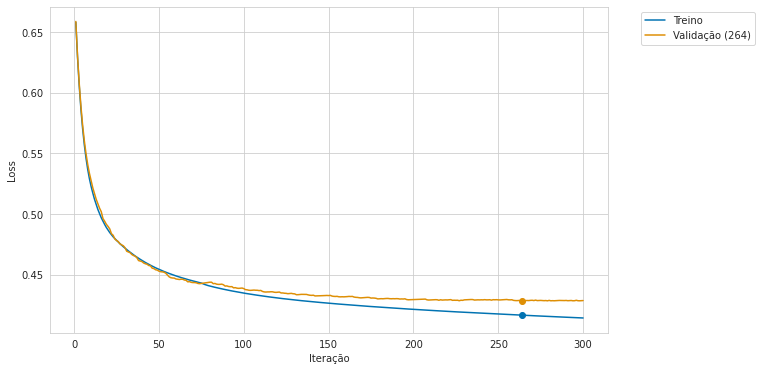

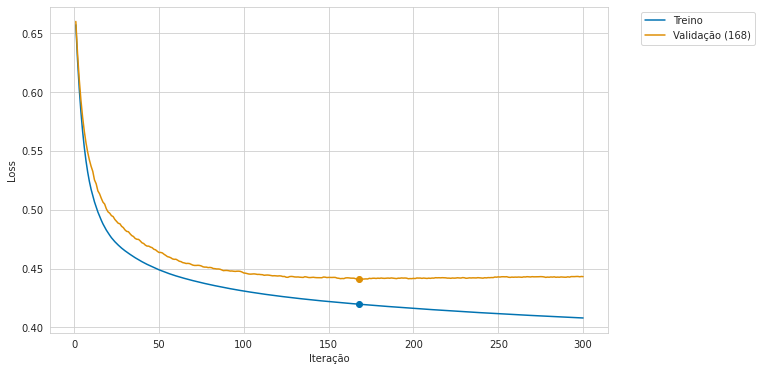

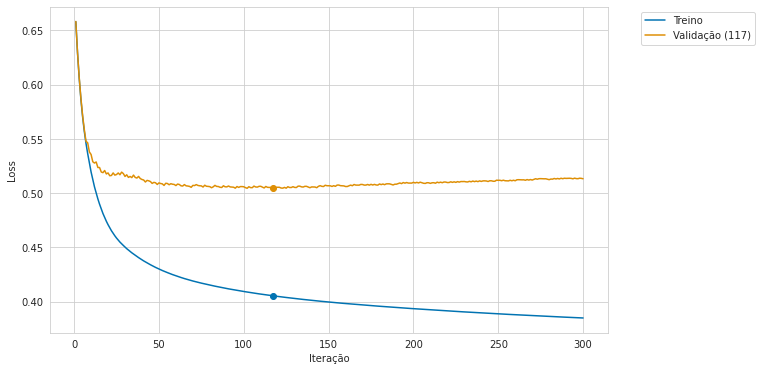

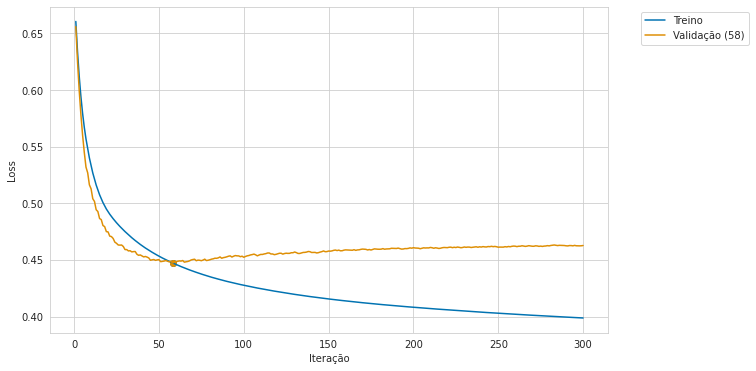

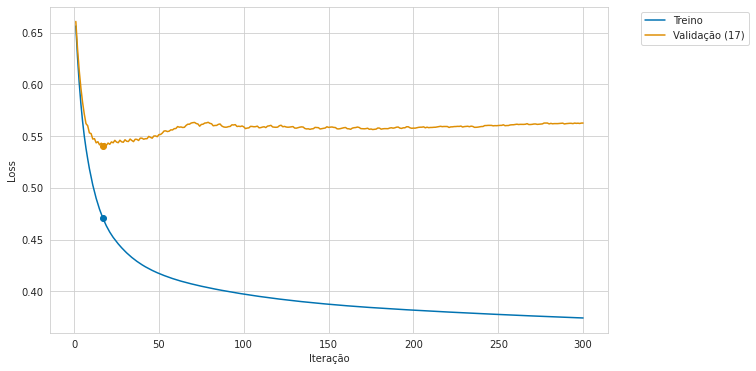

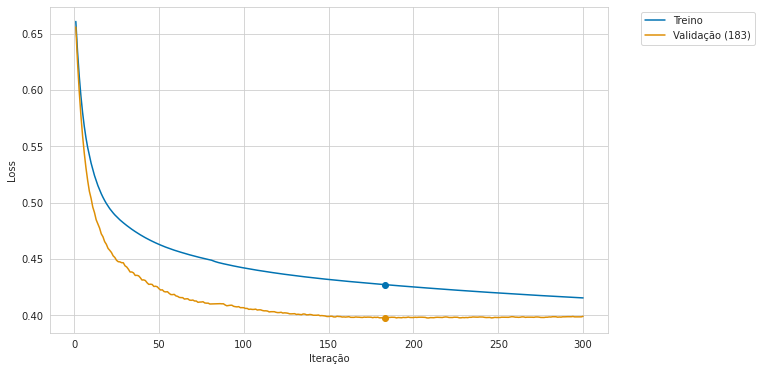

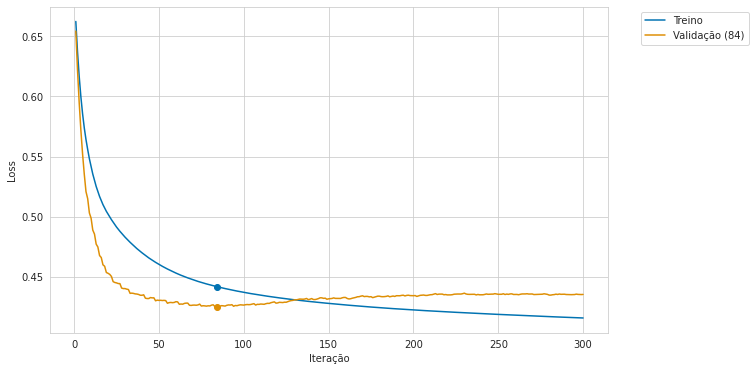

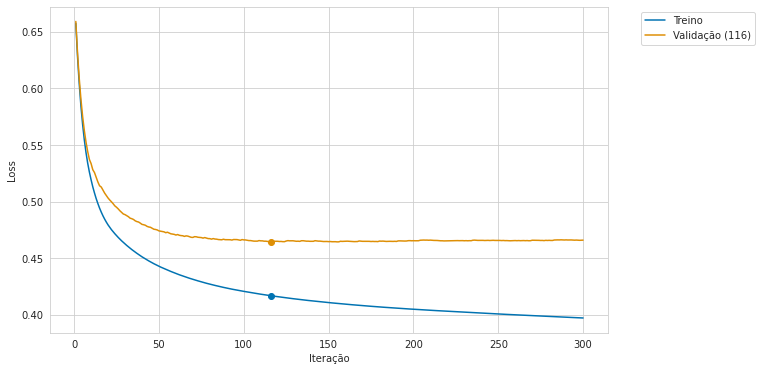

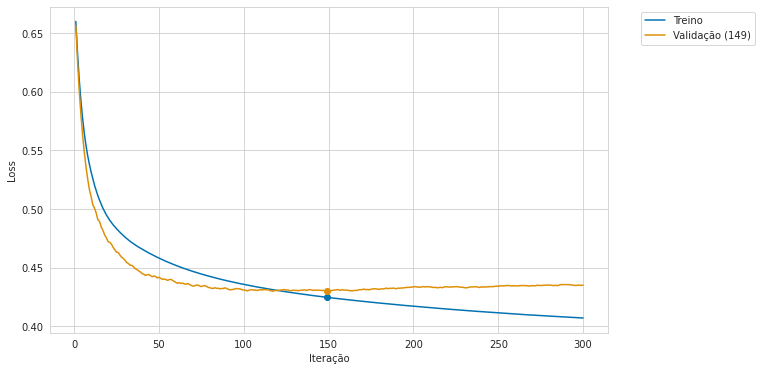

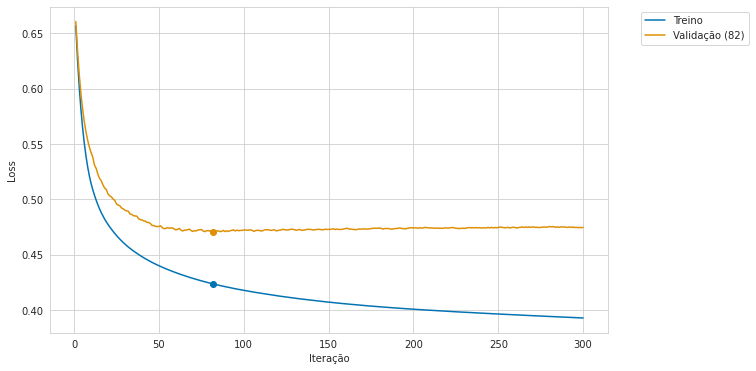

In [10]:
lista_clf = []
for i in range(0, len(lista_trainval)):
    index_train = lista_trainval[i][0]
    index_val = lista_trainval[i][1]

    clf = treino_com_validacao(df.loc[index_train, features], df.loc[index_train, target],
                               df.loc[index_val, features], df.loc[index_val, target],
                               max_estimators = 300)
    lista_clf.append(clf)

In [11]:
np.mean([clf.predict_proba(df[features]) for clf in lista_clf], axis = 0)

array([[0.2512712 , 0.7487289 ],
       [0.86670315, 0.13329688],
       [0.55825007, 0.44175   ],
       ...,
       [0.8554745 , 0.14452556],
       [0.11576287, 0.8842371 ],
       [0.82056075, 0.17943923]], dtype=float32)

#Criação do Ensemble

In [12]:
clf_ens = VotingClassifier(estimators = [(f'est{str(i)}', clone(lista_clf[i].estimators_[0])) for i in range(0, len(lista_clf))],
                           voting = 'soft')
clf_ens.fit(df[features].iloc[:100], df[target].iloc[:100])

#Força os Estimadores a serem os mesmos de lista_clf
for i in range(0, len(lista_clf)):
    clf_ens.estimators_[i] = lista_clf[i].estimators_[0]

In [13]:
clf_ens.predict_proba(df[features])

array([[0.2512712 , 0.7487289 ],
       [0.86670315, 0.13329688],
       [0.55825007, 0.44175   ],
       ...,
       [0.8554745 , 0.14452556],
       [0.11576287, 0.8842371 ],
       [0.82056075, 0.17943923]], dtype=float32)

# Converte Para PMML

In [14]:
pipeline = PMMLPipeline([
	("classifier", clone(clf_ens))
])
pipeline.fit(df[features].iloc[:100], df[target].iloc[:100])

#Força os Estimadores a serem os mesmos de lista_clf
clf_vot = pipeline.steps[0][1]
for i in range(0, len(lista_clf)):
    clf_vot.estimators_[i] = lista_clf[i].estimators_[0]

In [15]:
pipeline.predict_proba(df[features])

array([[0.2512712 , 0.7487289 ],
       [0.86670315, 0.13329688],
       [0.55825007, 0.44175   ],
       ...,
       [0.8554745 , 0.14452556],
       [0.11576287, 0.8842371 ],
       [0.82056075, 0.17943923]], dtype=float32)

In [16]:
sklearn2pmml(pipeline, 'EnsembleXGBoost.pmml', with_repr = True)

# Executa PMML

In [17]:
model = Model.fromFile('EnsembleXGBoost.pmml')

In [18]:
exemplo = df[features].to_dict(orient = 'records')[0]
print(exemplo)
result = model.predict(exemplo)
print(result)
print(pipeline.predict_proba(df[features].iloc[[0]]))

{'sex': 0, 'age': 29.0, 'n_siblings_spouses': 1, 'parch': 0, 'fare': 26.0, 'alone': 0}
{'probability(1)': 0.7487288462734203, 'probability(0)': 0.2512711537265798}
[[0.2512712 0.7487289]]


In [19]:
model.predict(df[features])

,probability(0),probability(1)
0,0.251271,0.748729
1,0.866703,0.133297
2,0.558250,0.441750
3,0.579467,0.420533
4,0.856288,0.143712
...,...,...
559,0.628872,0.371128
560,0.558250,0.441750
561,0.855474,0.144526
562,0.115763,0.884237


# Avaliação do Classificador

In [20]:
ks_2samp(pipeline.predict_proba(df_teste.loc[df_teste[target] == 0, features])[:, 1],
         pipeline.predict_proba(df_teste.loc[df_teste[target] == 1, features])[:, 1])

KstestResult(statistic=0.6666666666666666, pvalue=2.708343812329872e-06)